# CVL_Assignment_02

Nama : Frederik Baptista Sakspari

NIM  : 24/550780/PPA/06957

Object Detection by Segmentation dengan referensi dari buku Digital Image Processing 4th edition by Rafael C. Gonzales dan Richard E. Woods

In [30]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# config plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 12


Citra input dan ground truth mask berhasil dimuat.


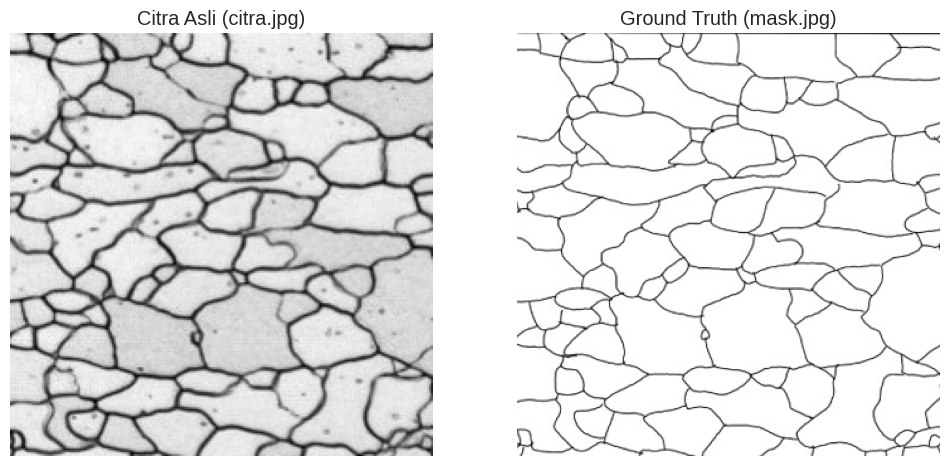

In [31]:
def load_image_grayscale(path):
    try:
        img = Image.open(path).convert('L') #  grayscale
        return np.array(img)
    except FileNotFoundError:
        print(f"Error: File tidak ditemukan di {path}")
        return None

IMAGE_PATH = 'dataset/citra.png'
MASK_PATH = 'dataset/mask.png'

# load citra input dan ground-truth mask
original_image = load_image_grayscale(IMAGE_PATH)
ground_truth_mask = load_image_grayscale(MASK_PATH)

# make sure data berhasil dimuat
if original_image is not None and ground_truth_mask is not None:
    print("Citra input dan ground truth mask berhasil dimuat.")
    
    # show citra awal
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Citra Asli (citra.jpg)')
    axes[0].axis('off')
    
    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title('Ground Truth (mask.jpg)')
    axes[1].axis('off')
    
    plt.show()

In [32]:
print(f'ukuran mask: {ground_truth_mask.shape}')
print(f'ukuran citra: {original_image.shape}')

ukuran mask: (336, 336)
ukuran citra: (224, 224)


In [33]:
# resample ukuran masks agar sesuai dengan citra
if ground_truth_mask.shape != original_image.shape:
    print("Ukuran ground truth mask tidak sesuai dengan citra. Melakukan resampling...")
    ground_truth_mask = np.array(Image.fromarray(ground_truth_mask).resize(original_image.shape[::-1], Image.NEAREST))
    print(f'Ukuran mask setelah resampling: {ground_truth_mask.shape}') 
    if ground_truth_mask.shape == original_image.shape:
        print("Resampling berhasil. Ukuran mask sekarang sesuai dengan citra.")
    else:
        print("Resampling gagal. Ukuran mask masih tidak sesuai dengan citra.")

Ukuran ground truth mask tidak sesuai dengan citra. Melakukan resampling...
Ukuran mask setelah resampling: (224, 224)
Resampling berhasil. Ukuran mask sekarang sesuai dengan citra.


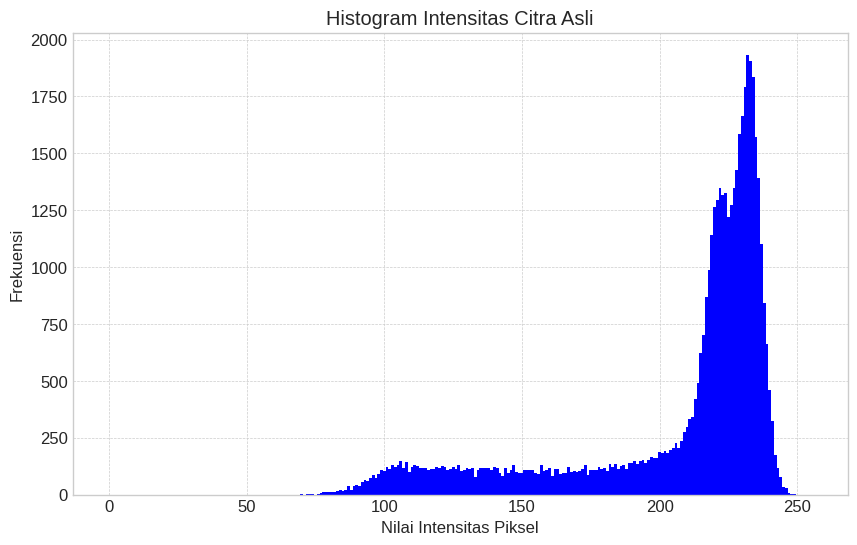

In [34]:
# Eksplorasi citra

def calculate_histogram(image):
    # define array kosong berukuran 256 untuk menampung frekuensi setiap intensitas
    hist = np.zeros(256, dtype=int)
    
    # iterasi di setiap piksel citra dan hitung frekuensinya
    for pixel_value in image.flatten():
        hist[pixel_value] += 1
        
    return hist

# kalkulasi histogram dari citra asli
image_hist = calculate_histogram(original_image)

# tampilkan histogram
plt.figure(figsize=(10, 6))
plt.bar(range(256), image_hist, width=1.0, color='b')
plt.title('Histogram Intensitas Citra Asli')
plt.xlabel('Nilai Intensitas Piksel')
plt.ylabel('Frekuensi')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [35]:
# Implementasi metode otsu
# Logika utama: Mencari threshold 't' yang memaksimalkan varian antar-kelas (between-class variance) --> referensi buku Digital Image Processing by Rafael C. Gonzales.
# Varian antar-kelas, sigma_b^2 = w_b * w_f * (mu_b - mu_f)^2
# w_b: bobot kelas background
# w_f: bobot kelas foreground
# mu_b: rata-rata intensitas kelas background
# mu_f: rata-rata intensitas kelas foreground

def otsu_thresholding_from_scratch(hist):
    total_pixels = sum(hist)
    
    # init variabel untuk menyimpan hasil terbaik
    best_threshold = 0
    max_variance = 0.0
    
    # array untuk menyimpan varian dari setiap kandidat threshold
    variances = []
    
    # kalkulasi total rata-rata intensitas (mean global) sekali saja
    total_mean = sum(i * hist[i] for i in range(256)) / total_pixels
    
    # inisialisasi bobot bg dan sum bg
    w_b = 0 # Bobot background
    sum_b = 0 # Jumlah intensitas terbobot untuk background
    
    # iterasi melalui semua kemungkinan threshold (1 sampai 254)
    for t in range(1, 256):
        # update bobot dan jumlah untuk kelas background
        w_b += hist[t-1]
        sum_b += (t-1) * hist[t-1]
        
        # hitung bobot kelas foreground
        w_f = total_pixels - w_b
        
        # if salah satu kelas kosong, variansnya 0
        if w_b == 0 or w_f == 0:
            variances.append(0)
            continue
            
        # kalkulasi rata-rata intensitas untuk kedua kelas
        mu_b = sum_b / w_b
        
        # rata-rata foreground bisa dihitung dari total mean
        mu_f = (total_pixels * total_mean - sum_b) / w_f
        
        # Hitung varian antar-kelas (cari nilai maksimum)
        between_class_variance = w_b * w_f * ((mu_b - mu_f) ** 2)
        variances.append(between_class_variance)
        
        if between_class_variance > max_variance:
            max_variance = between_class_variance
            best_threshold = t
            
    return best_threshold, variances

# threshold optimal dan varian kandidat
optimal_threshold, candidate_variances = otsu_thresholding_from_scratch(image_hist)

print(f"Threshold Optimal: {optimal_threshold} dengan varian maksimum antara kelas {max(candidate_variances)}")

Threshold Optimal: 179 dengan varian maksimum antara kelas 3197665130760.5557


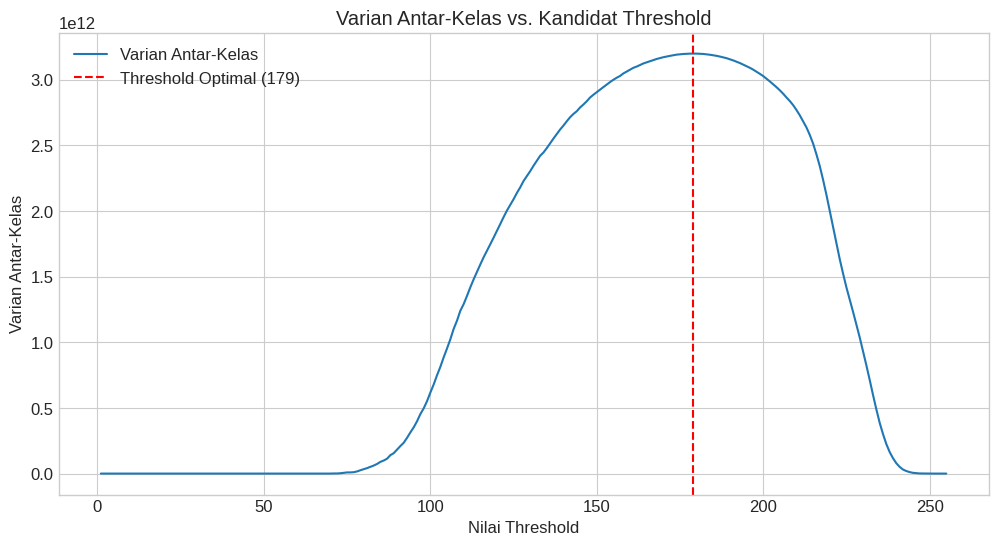

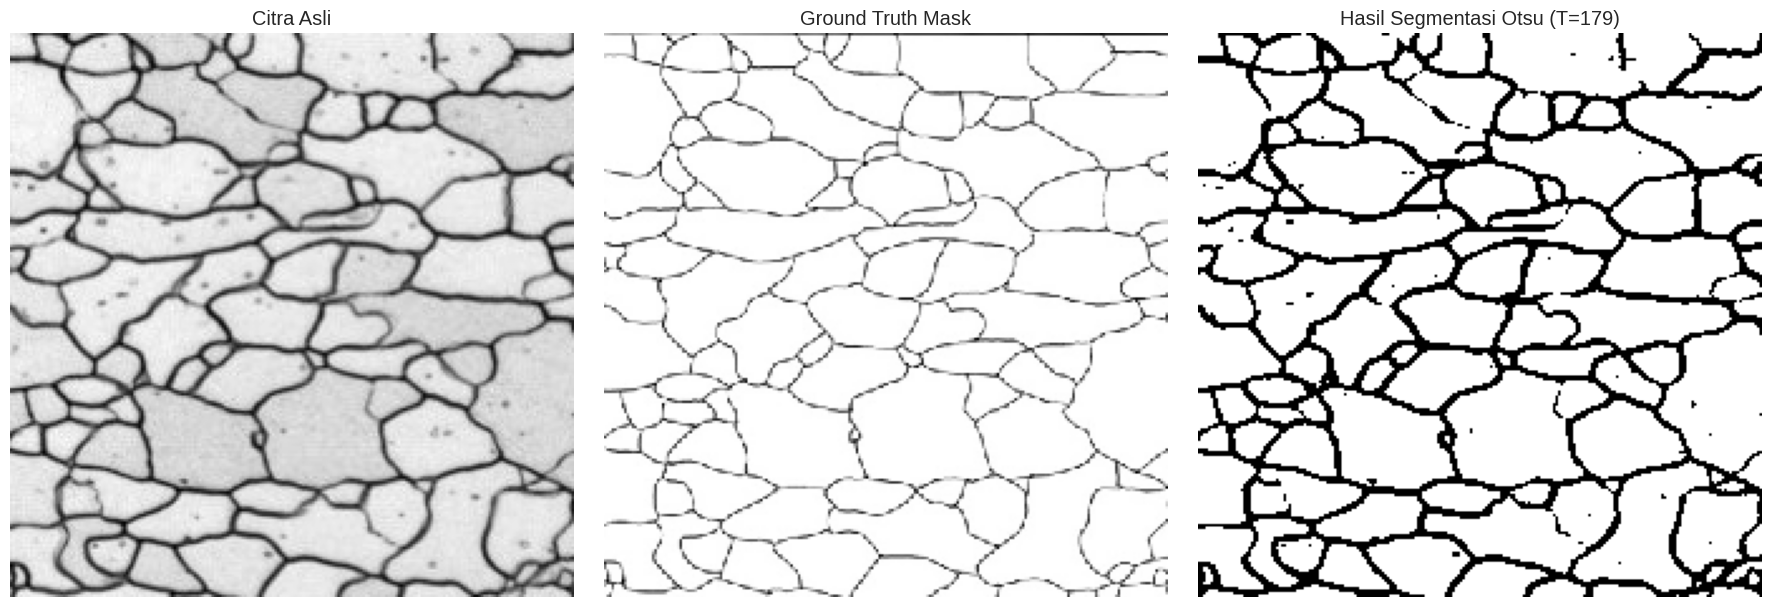

In [36]:
# plot varian antar-kelas (cari yang paling maksimum) 
# tampilkan plot varian antar-kelas untuk setiap kandidat threshold
plt.figure(figsize=(12, 6))
plt.plot(range(1, 256), candidate_variances, label='Varian Antar-Kelas')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Threshold Optimal ({optimal_threshold})')
plt.title('Varian Antar-Kelas vs. Kandidat Threshold')
plt.xlabel('Nilai Threshold')
plt.ylabel('Varian Antar-Kelas')
plt.legend()
plt.grid(True)
plt.show()


# Fungsi untuk menerapkan threshold ke citra
def apply_threshold(image, threshold):
    """Membuat citra biner berdasarkan threshold."""
    # Buat citra baru dengan nilai 0 (hitam)
    binary_image = np.zeros_like(image, dtype=np.uint8)
    # Dimana piksel > threshold, set menjadi 255 (putih)
    binary_image[image > threshold] = 255
    return binary_image

# Menerapkan threshold optimal ke citra asli
segmented_image = apply_threshold(original_image, optimal_threshold)

# Menampilkan hasil akhir
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Citra Asli')
axes[0].axis('off')

axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(segmented_image, cmap='gray')
axes[2].set_title(f'Hasil Segmentasi Otsu (T={optimal_threshold})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [37]:
# Akurasi dan IoU

def calculate_accuracy(predicted_mask, gt_mask):
    """Menghitung akurasi piksel-ke-piksel."""
    # Normalisasi masker ke nilai boolean (True/False)
    # Asumsi: > 0 adalah objek
    pred = predicted_mask > 0
    gt = gt_mask > 0
    
    # Jumlah piksel yang benar (True Positive + True Negative)
    correct_pixels = np.sum(pred == gt)
    total_pixels = pred.size
    
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_iou(predicted_mask, gt_mask):
    """Menghitung Intersection over Union (IoU) atau Jaccard Index."""
    # Normalisasi masker ke nilai boolean
    pred = predicted_mask > 0
    gt = gt_mask > 0
    
    # Intersection (irisan): piksel yang True di kedua masker
    intersection = np.logical_and(pred, gt)
    
    # Union (gabungan): piksel yang True di salah satu atau kedua masker
    union = np.logical_or(pred, gt)
    
    # Menghindari pembagian dengan nol jika union kosong
    if np.sum(union) == 0:
        return 1.0 # Jika tidak ada objek di pred dan gt, IoU adalah 1
    
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# hitung metrik performa
accuracy = calculate_accuracy(segmented_image, ground_truth_mask)
iou = calculate_iou(segmented_image, ground_truth_mask)

print("Hasil Evaluasi")
print(f"Akurasi: {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Intersection over Union (IoU): {iou:.4f} ({iou * 100:.2f}%)")

Hasil Evaluasi
Akurasi: 0.8040 (80.40%)
Intersection over Union (IoU): 0.8040 (80.40%)
